In [9]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

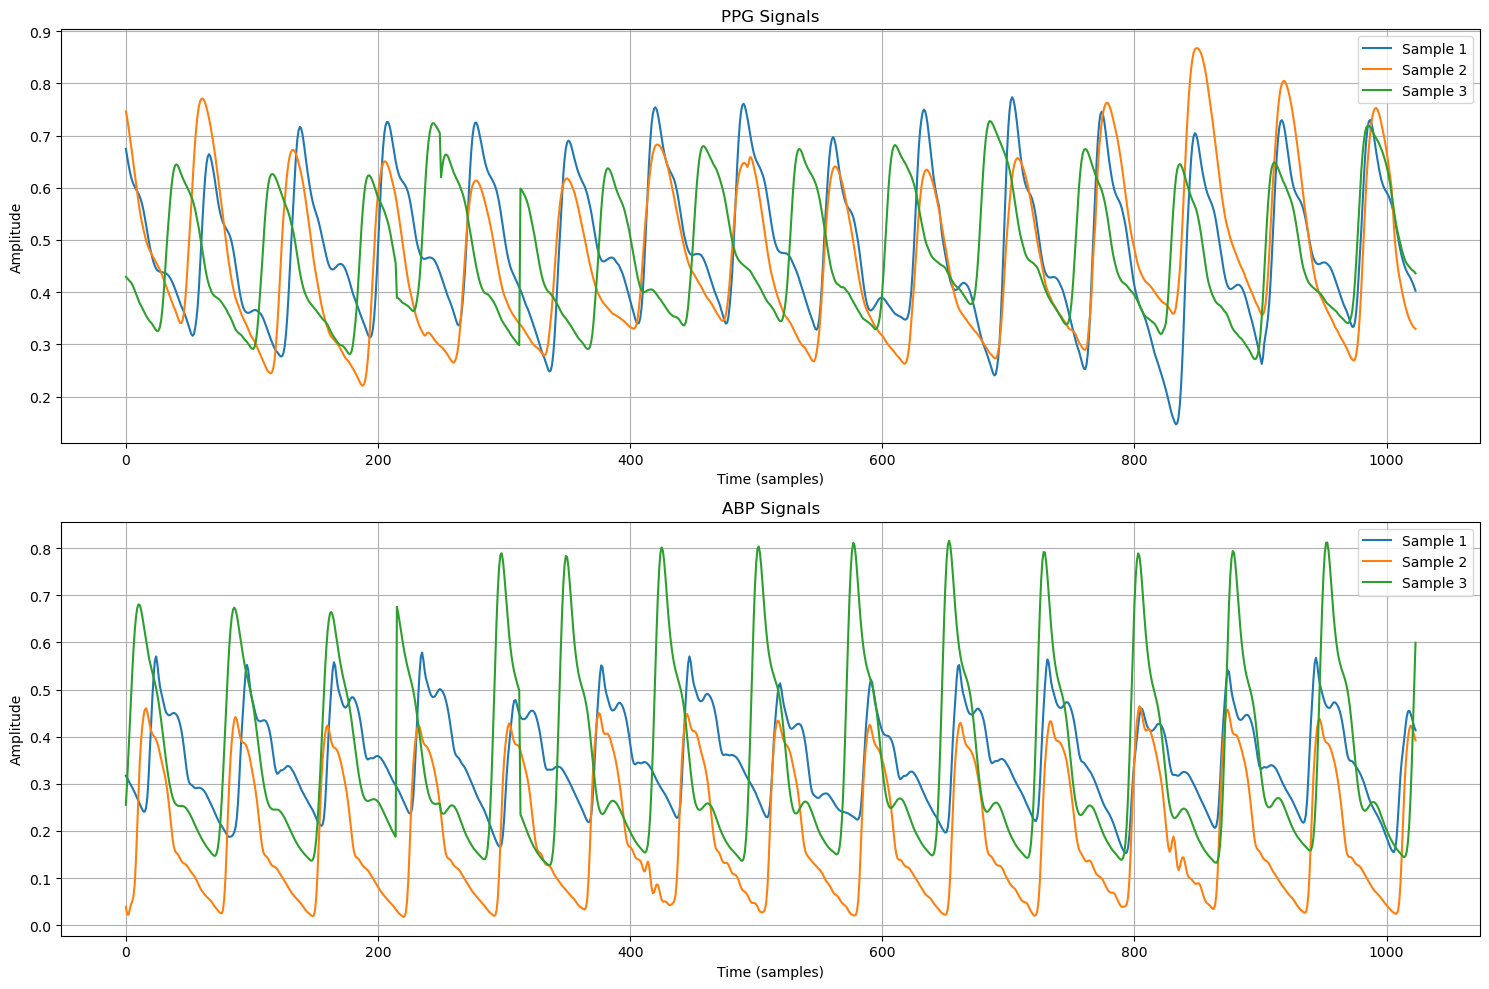

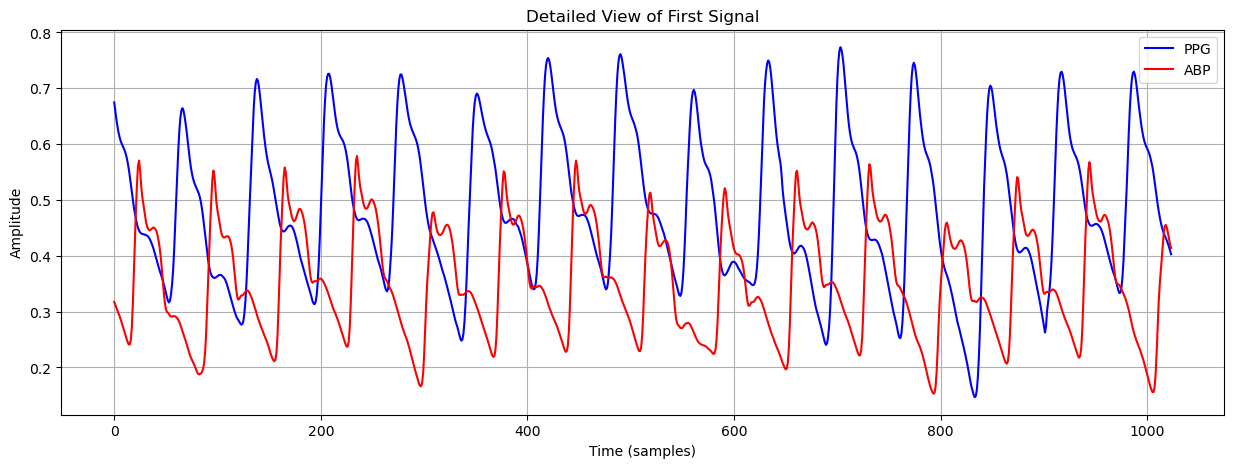

Data Statistics:
Number of samples: 27260
Length of each signal: 1024
PPG Signal Range: 0.000 to 1.000
ABP Signal Range: 0.000 to 1.000


In [10]:
with open('../data/test.p', 'rb') as f:
    data = pickle.load(f)

# Get the signals
X_test = data['X_test']  # PPG signals
Y_test = data['Y_test']  # ABP signals

# Create time axis (assuming standard sampling rate)
time = np.arange(0, len(X_test[0]))

# Create a figure with subplots
plt.figure(figsize=(15, 10))

# Plot first few samples to avoid overcrowding
num_samples_to_plot = 3

# Plot PPG signals
plt.subplot(2, 1, 1)
for i in range(num_samples_to_plot):
    plt.plot(time, X_test[i], label=f'Sample {i+1}')
plt.title('PPG Signals')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot ABP signals
plt.subplot(2, 1, 2)
for i in range(num_samples_to_plot):
    plt.plot(time, Y_test[i], label=f'Sample {i+1}')
plt.title('ABP Signals')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Also create a single signal detailed view
plt.figure(figsize=(15, 5))
plt.plot(time, X_test[0], 'b-', label='PPG')
plt.plot(time, Y_test[0], 'r-', label='ABP')
plt.title('Detailed View of First Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Print some basic statistics
print("Data Statistics:")
print(f"Number of samples: {len(X_test)}")
print(f"Length of each signal: {len(X_test[0])}")
print(f"PPG Signal Range: {np.min(X_test):.3f} to {np.max(X_test):.3f}")
print(f"ABP Signal Range: {np.min(Y_test):.3f} to {np.max(Y_test):.3f}")